## PneumoScan

- This notebook trained on Colab, because training process needs powerfull GPU.

## Download and Install Packages

In [1]:
!pip install -q torch torchvision torchinfo gradio

## Configure Kaggle API

In [2]:
# Kaggle API тохируулах (эхний удаа л хийнэ)
from google.colab import files
print("kaggle.json файлаа upload хийнэ үү")
files.upload()  # kaggle.json-г сонго

kaggle.json файлаа upload хийнэ үү


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n    "username": "tsejavhaa",\n    "key": "KGAT_235f189c4363503819441a8c8d9558a7"\n}'}

In [3]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the uploaded kaggle.json file to the .kaggle directory
# Make sure you have uploaded the kaggle.json file to your Colab environment first
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Kaggle API configured successfully!


## Download Dataset From Kaggle

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d chest_xray
!rm chest-xray-pneumonia.zip

print("Dataset бэлэн! → /content/chest_xray")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:36<00:00, 91.8MB/s]
100% 2.29G/2.29G [00:36<00:00, 67.4MB/s]
Dataset бэлэн! → /content/chest_xray


## Import Libraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Set Device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ашиглаж буй төхөөрөмж: {device}")

Ашиглаж буй төхөөрөмж: cuda


## Data Transforms
- Augmentation
- Normalize

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Create Dataset and DataLoader

In [8]:
data_dir = "/content/chest_xray/chest_xray"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"),   transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"),  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)

class_names = train_dataset.classes
print("Ангилал:", class_names)  # ['NORMAL', 'PNEUMONIA']

Ангилал: ['NORMAL', 'PNEUMONIA']


## Set Model
- Use EfficientNet-B0 Model from PyTorch

In [9]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Change classifier to Binary Classification
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 2)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]


In [10]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

## Set Loss, Optimizer and Scheduler

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)

## Training Function

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

## Eval Function

In [14]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return running_loss / len(loader), correct / total, all_preds, all_labels

## Training

10-15 epoch on GPU

In [15]:
best_acc = 0.0
epochs = 12

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/content/best_pneumonia_model.pth")
        print(f"→ New best model saved! Val Acc: {best_acc:.4f}")

print(f"\Training done! Best Val Accuracy: {best_acc:.4f}")

<>:19: SyntaxWarning: invalid escape sequence '\T'
<>:19: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2028639224.py:19: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Training done! Best Val Accuracy: {best_acc:.4f}")


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.2265 | Train Acc: 0.9064 | Val Loss: 0.6878 | Val Acc: 0.6250
→ New best model saved! Val Acc: 0.6250


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/12 | Train Loss: 0.1585 | Train Acc: 0.9392 | Val Loss: 0.5666 | Val Acc: 0.6250


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/12 | Train Loss: 0.1447 | Train Acc: 0.9459 | Val Loss: 0.1463 | Val Acc: 1.0000
→ New best model saved! Val Acc: 1.0000


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/12 | Train Loss: 0.1322 | Train Acc: 0.9494 | Val Loss: 0.1602 | Val Acc: 1.0000


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/12 | Train Loss: 0.1212 | Train Acc: 0.9526 | Val Loss: 0.2546 | Val Acc: 0.9375


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/12 | Train Loss: 0.1072 | Train Acc: 0.9605 | Val Loss: 0.1912 | Val Acc: 0.9375


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/12 | Train Loss: 0.1073 | Train Acc: 0.9601 | Val Loss: 0.2310 | Val Acc: 0.9375


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/12 | Train Loss: 0.0931 | Train Acc: 0.9651 | Val Loss: 0.0900 | Val Acc: 1.0000


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/12 | Train Loss: 0.0922 | Train Acc: 0.9661 | Val Loss: 0.1315 | Val Acc: 0.9375


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/12 | Train Loss: 0.0790 | Train Acc: 0.9714 | Val Loss: 0.1238 | Val Acc: 0.9375


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/12 | Train Loss: 0.0801 | Train Acc: 0.9711 | Val Loss: 0.1802 | Val Acc: 0.9375


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/12 | Train Loss: 0.0744 | Train Acc: 0.9711 | Val Loss: 0.1784 | Val Acc: 0.9375
\Training done! Best Val Accuracy: 1.0000


## Accuracy

In [16]:
model.load_state_dict(torch.load("/content/best_pneumonia_model.pth"))
test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)

print(f"\nTest Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


Test Accuracy: 0.9471

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.87      0.92       234
   PNEUMONIA       0.93      0.99      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.93      0.94       624
weighted avg       0.95      0.95      0.95       624



## Confusion Matrix

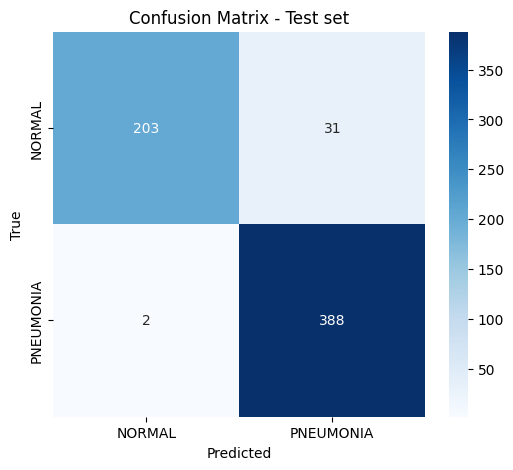

In [17]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test set')
plt.show()

## Gradio Demo

In [18]:
!pip install -q gradio

import gradio as gr
from PIL import Image

def predict_pneumonia(img):
    # Gradio-оос ирсэн зургийг бэлтгэх
    img = Image.fromarray(img).convert('RGB')
    img = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        probs = torch.nn.functional.softmax(output, dim=1)[0]
        confidences = {class_names[i]: float(probs[i]) for i in range(2)}

    return confidences

In [19]:
demo = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=2),
    title="PneumoScan - Chest X-ray Pneumonia Detector",
    description="EfficientNet-B0 дээр сургагдсан | Ex-surgeon & ML engineer бүтээв",
    examples=[
        ["/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg"],
        ["/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg"],
        ["/content/chest_xray/chest_xray/test/NORMAL/IM-0010-0001.jpeg"],
        ["/content/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"],
        ["/content/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg"],
        ["/content/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg"],
        ["/content/chest_xray/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg"]
    ]
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2cc83c8727baa554e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
